# FORT Atom Dynamics Simulator (FADS) #
Preston Huft, July 2019

For simulating atom dynamics in a far-off resonance trap (FORT), including
- chopped cooling
- release recapture temperature measurements
- power modulation resonance searches (parametric heating)

# notes and todo

- all methods added so far work
- do single atom case studies to test functionality
- make experiment class in which FORT on/off times, chopping phases,
    and drops are set, following our experiment cycle design
    - plot the waveform to check
    - do atom exp with 100% single atom loading and simulated "second"
        readout checking whether the atom position is within the FORT
        radius


# pseudocode here

do this with objects. have an atom class, an experiment class to set FORT on off times, etc. 
do this for several atoms, say 100: 
capture an atom with a random velocity corresponding to a given T, say 25 uK
integrate the differential eq for the FORT being on either continuously or chopped (state machine it?)
the eq should use the dipole force given a gaussian intensity profile in r, and whatever shape the focus is
calculate things like mean squared velocity in the FORT to track temp, kinetic energy

In [4]:
# %matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np
from numpy import linspace,sin,cos,log,exp
import math as m
from math import sqrt,pi,e,exp
from random import random as rand
from scipy.integrate import solve_ivp
from physconsts import *
from rbconsts import *

In [5]:
# ## physical constants
# ee = 1.60217662e-19 # [C]
# a0 = 5.22e-11 # [m]
# hbar = 1.0545718e-34 # [J s]
# c = 299792458 # [m/s]
# e0 = 8.85418782e-12 # [m^-3 kg^-1 s^4 A^2]
# u0 = 1.25663706e-6 # [m kg s^-2 A^-2]
# me = 9.10938356e-31 # [kg]
# uB = 9.274e-24 # [J/T]
# kB = 1.3807e-23 # [J/K]

# ## Rb87 constants
# mRb = 1.4192261e-25 # [kg]
# I = 3/2 # nuclear spin
# nu_hf = 6.83468261090429 # [GHz]
# gamma_D2 =2*pi*6.0659e6 ; # [rad/s]
# lambda_D2 = 7.8e-7 # [m]
# omega_D2 = 2*pi*c/lambda_D2
# gS = 2.00023
# gL = 1 # for ground state?
# gI = -0.000995
# Isat = (5/7)*(hbar*gamma_D2*omega_D2**3
#              /(12*pi*c**2)) 
#     # saturation intensity for D2 cooling W/m^2

# ## reduced matrix elements from Steck
# D2_MatElem = 3.584e-29 # <J=1/2||er||J'=3/2> [C*m]
# D1_MatElem = 2.537e-29 # <J=1/2||er||J'=1/2> [C*m]

In [6]:
## methods

# could sampling a class. can get normalization, max, etc
# via object properties
def maxboltzv(T,v,normalization=False):
    """ Maxwell-Boltzmann distribution of speeds for 3-dimensional
        gas. Returns f(v) for T. """
    global kB,mRb
    m = mRb
    
    A = 4*pi*(m/(2*pi*kB*T))**(3/2) # normalization consts
    meanv = sqrt(2*kB*T/m) # the maximum occurs at the mean
    
    if normalization is True:
        return A
    else:
        return A*v**2*exp(-m*v**2/(2*kB*T))

def sampling_maxboltzv(size,domain,T,vectorial=False,showplot=False):
    """ Sample random speeds with a Maxwell-Boltzmann dist. 
        'size': sample size
        'domain': [v1,v2] the restricted domain of the pdf; e.g.
            a Guassian goes to zero well before inf so we could
            let the domain be a finite region
        'T': temperature
        'vectorial': 
            If False, only return a scalar. 
            Set to True to return velocity vectors with a 
            direction from a flat distribution. 
    """
    global kB,mRb
    m = mRb
    
    n = size 
    v1,v2 = domain
    
    mean = sqrt(2*kB*T/m)
    fmax = maxboltzv(T,mean) # the maximum
    y_dist = np.empty(n) 
    f_dist = np.empty(n) 
    v_dist = np.empty(n) # this is the distribution we want
    j = 0 # dist index
    while j < n:
        v = (v2-v1)*rand() # rand val on domain of f(x)
        f = maxboltzv(T,v)
        y = rand()*fmax # rand val on range of f(x)
        if y <= f:
            y_dist[j]=y
            f_dist[j]=f
            v_dist[j]=v # x vals with approximate gaussian pdf
            j+=1
            
    # plot distribution as a check:
    if showplot is not False:
        plt.scatter(v_dist,y_dist,c='red',s=10)
        plt.scatter(v_dist,f_dist,c='blue',s=10)
        plt.show()
    
    return v_dist

def squarewave(d,tau,t,n):
    """ square wave with duty cycle 'd' and period 'tau' [s]
        evaluated at time 't' % tau. 
        'n': number of Fourier terms
    """
    t = t % tau
    
    term = lambda m: 2*(1-cos(m*pi*d))*sin(m*pi*t/tau)/(m*pi)
    sqwv = 0
    for i in range(1,n):
        sqwv += term(i)
    
    return sqwv

def fr_dipole(r,delta,w0,I0,dist='Gaussian'):
    """ Radial component of dipole force felt by an atom located at
        r. 
        'delta': light detuning from the relevant transition
        'w0': characteristic trap radius, e.g. gaussian waist
        'dist': trap cross section shape, e.g. poisson
        'I0': peak spatial intensity
    """
    global hbar,Isat,gamma_D2
    
    # assume dist = Gaussian for now
    I = lambda x: I0*exp(-x**2/w0**2)
    gradI = lambda x: -2*I0*x*exp(-x**2/w0**2)/w0**2
    
    fdip = -(hbar*delta/2)*((gradI(r)/Isat)
                            /(1+4*(delta/gamma_D2)**2)+I(r)/Isat)
    return fdip

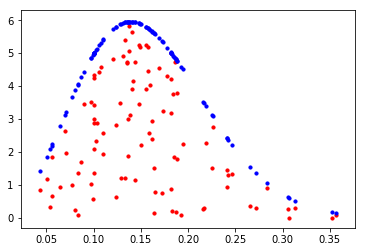

array([0.05031904, 0.16022072, 0.12368087, 0.18210439, 0.1441617 ,
       0.35623461, 0.08079643, 0.13866883, 0.28384205, 0.12351311,
       0.13649289, 0.24698723, 0.05384434, 0.10087377, 0.1105479 ,
       0.14078849, 0.10608007, 0.18553234, 0.14388256, 0.10094857,
       0.10089314, 0.16233102, 0.10254153, 0.1591462 , 0.21858024,
       0.22513252, 0.13103628, 0.16188067, 0.1008852 , 0.18818937,
       0.12953205, 0.09923932, 0.14952402, 0.24122295, 0.18318945,
       0.17357794, 0.24161754, 0.05614382, 0.17206107, 0.10019745,
       0.08968118, 0.27187404, 0.14804693, 0.21675937, 0.10063368,
       0.13727539, 0.35232961, 0.16513552, 0.18203173, 0.30536454,
       0.1885234 , 0.064568  , 0.14193937, 0.19440926, 0.07091191,
       0.08385346, 0.05562571, 0.18214976, 0.13556871, 0.26572861,
       0.13719111, 0.08699479, 0.15012977, 0.16936913, 0.15721296,
       0.3070394 , 0.24256281, 0.134952  , 0.15595178, 0.1638083 ,
       0.22592606, 0.16432704, 0.181818  , 0.06936911, 0.14849

In [59]:
# maxwboltz test
sampling_maxboltzv(100,[0,1],.000100,showplot=True)

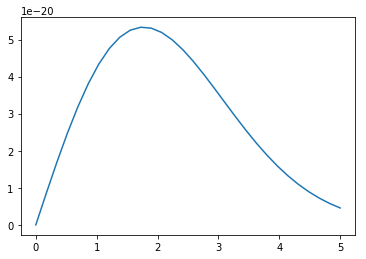

In [165]:
# fr_dipole test
w0 = 2.5e-6
D = 2e8
I0 = .4*.384/(pi*(w0)) 

rpts = linspace(0,5,30)
fpts = [fr_dipole(r*1e-6,D,w0,I0) for r in rpts]
plt.plot(rpts,fpts)

In [272]:
# FORT potential wrt inf and escape velocity
w0 = 2.5e-6
D = 2e8
I0 = .4*.384/(pi*(w0)) 
g = gamma_D2

# integral Fdip from 0 to inf in mathematica. Check Mark's notes
U = .5*hbar*w0**2*D*log(1+I0*g**2/(Isat*(g**2+4*D**2)))
U/kB # why is this so small?

# get escape vel from this

1.3158794269163735e-14

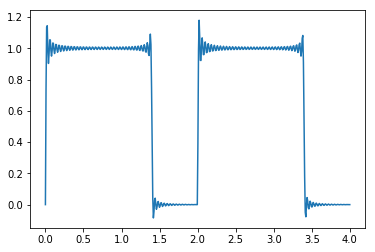

In [91]:
# squarewave test
tlist = linspace(0,4,500)
sqpts = [squarewave(0.7,2,t,100) for t in tlist]
plt.plot(tlist,sqpts)

In [376]:
## classes 

class RbEnsemble():
    """ Ensemble of Rb atoms with a momentum distribution specified
        by temperature. Optional spatial distribution.
        
        'T'= temperature
        'size'= number of atoms
        'xdist': optional parameter specifying the initial
            position distribution
    """
    global mRb
    
    
    def __init__(self,T,size=None,xdist=None):
        
        # For efficiency, pre-generate a specified number of atoms
        if size is not None:
            self.size = size
            self.temp = T
            self.v = sampling_maxboltzv(self.size,[0,1],self.temp) # rms
            self.p = mRb*self.v # rms
            self.x = np.empty(self.size)
            if xdist is None:
                self.x = np.zeros(self.size)
            elif xdist is 'normal':
                self.x = np.random.normal(0,size=self.size)
        else:
            self.size = 0
            self.temp = T
            self.v = np.array([]) # rms
            self.p = np.array([]) # rms
            self.x = np.array([])
            
    def phasespace(self):
        """ Plots the ensemble in phase space. 1D x and p only for 
            now.
        """
        xmax = max(self.x) # like xmas but better
        xmin = min(self.x) # because i said so
        dx = xmax-xmin
        
        pmax = max(self.p)/mRb
        pmin = min(self.p)/mRb
        dp = pmax-pmin
        
        fig, ax = plt.subplots()
        ax.scatter(self.p/mRb,self.x)#,linestyle=None)
        ax.set(xlabel='p [m/(s mRb)]', ylabel='r [arb]',
               xlim=(pmin-.1*dp,pmax+.1*dp),
               ylim=(xmin-.1*dx,xmax*+.1*dx))
        plt.show()
        
    def vpt(self):
        """ Return a speed from Maxwell-Boltzmann dist. """
        return sampling_maxboltzv(1,[0,1],self.temp)
    
    def xpt(self,domain):
        """ Return a position from a flat dist by default. """
        
        x1,x2 = domain
        x = rand()*(x2-x1) # only works for x1,x2 > 0
        return x
        
        
class Experiment():
    """ Do some science """
    
    global mRb

    ## experimental constants and methods
    w0 = 2.5e-6 # FORT width
    D = 2e8 # FORT detuning [Hz] from D2 cooling line
    I0 = .4*.384/(pi*(w0)) # FORT peak intensity
    lowpow = .7 # FORT low power setting [percentage]
    fdip = lambda r: fr_dipole(r,D,w0,I0) # FORT dipole F_r
    
    def __init__(self,atoms): 
        
        # later could just inherit RbEnsemble 
        self.atoms = atoms 
        
        # all times in [ms] for now
        self.t_exp = 100 
        self.t_FORTload = 0
        self.t_FORTdrop = [] # duration of FORT turned off
        self.t_chop = [] # duration of chopping
        self.chopduty = [] # chop duty cycle
        self.chopperiod = [] # chop period

        scan = self.t_FORTdrop # account for other vars later
        
    def derivs_on(self,t,y): 
        m = mRb

        v,r = y

        vdot = -fdip(r)/m
        rdot = v

        return [vdot,rdot]

    def derivs_off(self,t,y): 
        m = mRb

        v,r = y

        vdot = 0
        rdot = v

        return [vdot,rdot]
    
    def derivs_low(self,t,y): 
        m = mRb

        v,r = y

        vdot = -lowpow*fdip(r)/m
        rdot = v

        return [vdot,rdot]


    
    def derivs_chop(self,t,y):
        m = mRb

        v,r = y

        vdot = -fdip(r)*sqwv(t)/m
        rdot = v

        return [vdot,rdot] 
        
    def temp_exp(self,samples):
        """ release recapture 
            'samples' = number of measurements per data point
        """ 
        
        # not working; plot looks null, despite loop finishing, which implies
        # at least sample atoms were retained at loading... i guess.
        # no more programmatic errors though
        
        t_drop = 30e-3 # drop the FORT at .030 s
        t_exp = self.t_exp*1e-3 # convert to s
        t_steps = 500
        t_gap = self.t_FORTdrop*1e-3
        
        atoms = self.atoms
        
        retentions = np.empty(len(self.t_FORTdrop)) # atoms not lost to FORT drop
        
        for i,t_gap in enumerate(self.t_FORTdrop):
            retention = 0
            final_r = np.empty(samples)
            for s in range(samples):

                # FORT on CW
                tdomain = [0,t_drop]
                tlist = linspace(0,t_drop,t_steps)
                y0 = [atoms.xpt([0,w0]),atoms.vpt()]
    
#                 soln1 = solve_ivp(self.derivs_on,tdomain,y0,t_eval=tlist)
                
#                 # check if atom has been retained thus far
#                 r = soln1.y[0][-1]
#                 v = soln1.y[1][-1]
                
#                 final_r[s]=r
                
# #                 if r > w0: # abort this iteration
# #                     s -= 1 # don't advance the counter; 
# # #                     break
# #                 else:
# #                     retention+=1

                # FORT off 
                tdomain = [t_drop,t_gap]
                tlist = linspace(t_drop,t_gap,t_steps)
                soln2 = solve_ivp(self.derivs_off,tdomain,y0,t_eval=tlist)
                
                # atom still within FORT cross-section after t_gap?
                r = soln2.y[0][-1]
                if r <= w0:
                    retention += 1

#             plt.plot(final_r/(1e-6)) # plot the final r vals

            print(f"iter {i}: loading = {retention/samples}")
            retentions[i] = retention/samples
            
#         fig,ax = plt.subplots()
#         ax.plot(t_gap/(1e-3),retentions)
#         ax.set(xlim=[0,t_exp/(1e-3)],ylim=[0,1])
#         plt.show()

        #return [t_FORTdrop,retentions]
            

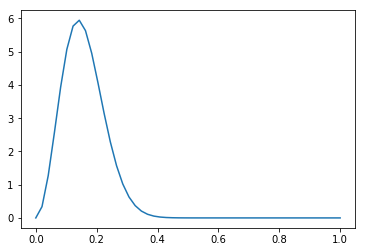

In [51]:
# maxboltz test
vlist = linspace(0,1,50) # [m/s]
f = [maxboltzv(.000100,v) for v in vlist]
plt.plot(vlist,f)

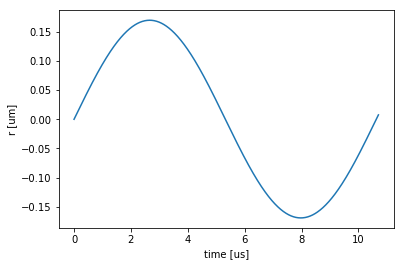

In [20]:
# ode solve test

tau = 8e-7 # 800 ns
texp = 10.7e-6
tlist = linspace(0,texp,1000)
sqwv = lambda t: squarewave(0.5,tau,t,100)
sqpts = [sqwv(t) for t in tlist]
# plt.plot(tlist/1e-9,sqpts)

w0 = 2.5e-6
D = 2e8
I0 = .4*.384/(pi*(w0)) 

fdip = lambda r: fr_dipole(r,D,w0,I0)

def derivs(t,y):
    global mRb
    m = mRb
    
    v,r = y
    
    vdot = -fdip(r)/m #*sqwv(t)/m
    rdot = v
    
    return [vdot,rdot]

tdomain = [0,texp]
y0 = [.1,0] # [v0 [m/s] ,r0 [m]]

soln = solve_ivp(derivs,tdomain,y0,t_eval=tlist)
# plt.plot(soln.t/1e-6,soln.y[1]/1e-6)

fig, ax = plt.subplots()
ax.plot(soln.t/1e-6,soln.y[1]/1e-6)
# ax.plot(soln.t/1e-6,sqpts)
ax.set(xlabel='time [us]', ylabel='r [um]')
plt.show()
    
# solve_ivp(func,[0,t_exp],y0,t_eval=np.linspace(0,t_exp,50))

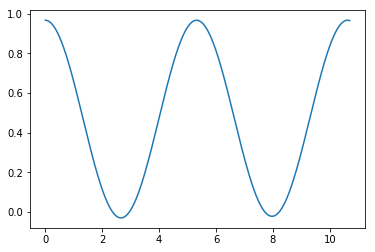

In [25]:
# the AC stark shift the atom sees
fig, ax = plt.subplots()
acshift = [(I0*exp(-y**2/w0**2)-19470)/90 for y in soln.y[1]]
ax.plot(soln.t/1e-6,acshift)

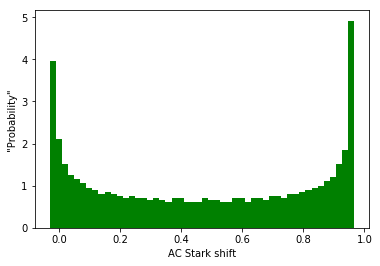

In [27]:
# time spent in various regions of stark shift histogram
n, bins, patches = plt.hist(acshift, 50, density=True, facecolor='g')

plt.xlabel('AC Stark shift')
plt.ylabel('"Probability"')
plt.show()

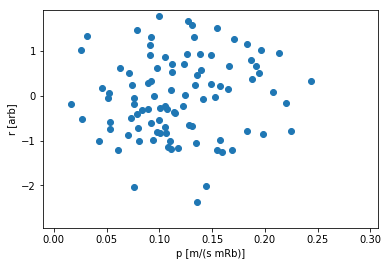

In [304]:
# RbEnsemble test
atoms = RbEnsemble(5e-5,100,xdist='normal')
atoms.phasespace()

In [377]:
# Experiment test. don't name the experiment 'exp' !!
atom = RbEnsemble(5e-5)
exp1 = Experiment(atom)
exp1.t_FORTdrop = np.array([0,0.002,0.004,0.008,0.01,0.012,0.014,0.016,0.018,
                            0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16]) # [ms]

In [378]:
exp1.temp_exp(10)

iter 0: loading = 1.0
iter 1: loading = 1.0
iter 2: loading = 1.0
iter 3: loading = 1.0
iter 4: loading = 1.0
iter 5: loading = 1.0
iter 6: loading = 1.0
iter 7: loading = 1.0
iter 8: loading = 1.0
iter 9: loading = 1.0
iter 10: loading = 1.0
iter 11: loading = 1.0
iter 12: loading = 1.0
iter 13: loading = 1.0
iter 14: loading = 1.0
iter 15: loading = 1.0
iter 16: loading = 1.0


In [ ]:
()